# Task 1
Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events

In [24]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras

# Check Keras documentation
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate as tf_concatenate # Rename to avoid conflict if you have a local 'concatenate'
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import matplotlib.style
import matplotlib as mpl

from scipy import linalg

#Set default figure size
#mpl.rcParams["figure.figsize"] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["figure.dpi"]=150

#Useful for debugging problems
print(tf.__version__)

2.18.0


In [25]:
import h5py
import enum 

class Interaction(enum.Enum):
    kNumuQE = 0             # Numu CC QE interaction
    kNumuRes = 1            # Numu CC Resonant interaction
    kNumuDIS = 2            # Numu CC DIS interaction
    kNumuOther = 3          # Numu CC, other than above
    kNueQE = 4              # Nue CC QE interaction
    kNueRes = 5             # Nue CC Resonant interaction
    kNueDIS = 6             # Nue CC DIS interaction
    kNueOther = 7           # Nue CC, other than above
    kNutauQE = 8            # Nutau CC QE interaction
    kNutauRes = 9           # Nutau CC Resonant interaction
    kNutauDIS = 10          # Nutau CC DIS interaction
    kNutauOther = 11        # Nutau CC, other than above
    kNuElectronElastic = 12 # NC Nu On E Scattering
    kNC = 13                # NC interaction
    kCosmic = 14            # Cosmic ray background
    kOther = 15             # Something else.  Tau?  Hopefully we don"t use this
    kNIntType = 16          # Number of interaction types, used like a vector size


class FinalState(enum.Enum):
    kNumu0tr0sh = 0                    # Numu CC - no track no shower
    kNumu0tr1sh = 1                    # Numu CC - no track  1 shower
    kNumu0tr2sh = enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh = enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh = enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh = enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh = enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh = enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh = enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh = enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh = enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh = enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh = enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh = enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh = enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh = enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh = enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh = enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh = enum.auto()           # Nue CC - no track  2 shower
    kNue0trMsh = enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh = enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh = enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh = enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh = enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh = enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh = enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh = enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh = enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh = enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh = enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh = enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh = enum.auto()            # NC CC - no track no shower
    kNC0tr1sh = enum.auto()            # NC CC - no track  1 shower
    kNC0tr2sh = enum.auto()            # NC CC - no track  2 shower
    kNC0trMsh = enum.auto()            # NC CC - no track 3+ shower
    kNC1tr0sh = enum.auto()            # NC CC -  1 track no shower
    kNC1tr1sh = enum.auto()            # NC CC -  1 track  1 shower
    kNC1tr2sh = enum.auto()            # NC CC -  1 track  2 shower
    kNC1trMsh = enum.auto()            # NC CC -  1 track 3+ shower
    kNC2tr0sh = enum.auto()            # NC CC -  2 track no shower
    kNC2tr1sh = enum.auto()            # NC CC -  2 track  1 shower
    kNC2tr2sh = enum.auto()            # NC CC -  2 track  2 shower
    kNC2trMsh = enum.auto()            # NC CC -  2 track 3+ shower
    kNCMtr0sh = enum.auto()            # NC CC - 3+ track no shower
    kNCMtr1sh = enum.auto()            # NC CC - 3+ track  1 shower
    kNCMtr2sh = enum.auto()            # NC CC - 3+ track  2 shower
    kNCMtrMsh = enum.auto()            # NC CC - 3+ track 3+ shower
    kCosmicFS = enum.auto()            # Cosmic ray background
    kOtherFS = enum.auto()             # Something else.  Tau?  Hopefully we don"t use this
    kNFStType = enum.auto()            # Number of interaction types, used like a vector size

Datasets in group:
cycle, 
evt, 
finalstate, 
finalstateprong, 
interaction, 
lepenergy, 
nuenergy, 
parent, 
particles, 
rec.training.trainingdata_idx, 
run, 
subevt, 
subrun, 
vtxx, 
vtxy, 
vtxz

In [26]:
import urllib.request

def import_data(start, end):

    # Initialise full array of metadata parameters for selected range
    nuenergy_full = np.zeros(0)
    lepenergy_full = np.zeros(0)
    interaction_bool_full = np.zeros(0)
    finalstate_full = np.zeros(0)

    df_full = np.zeros([0,2,100,80]) # Array containing all pairs of selected images
    
    for i in range(start, end, 1):
        # --- Import HDF5 Files ---
        # Import files from online nova folder
        #url = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino{i}.h5"
        #name = f"neutrino{i}.h5"
        #urllib.request.urlretrieve(url, name)
        #df = h5py.File(name, "r")

        # Import files from local nova folder
        name = f"nova/neutrino{i}.h5"
        df = h5py.File(name, "r")

        # --- Import metadata parameters ---
        # 1. Neutrino Energy (GeV)
        nuenergy = df["neutrino"]["nuenergy"][:]
        nuenergy_processed = [item for sublist in nuenergy for item in sublist] # Flattens nuenergy into a single list
        nuenergy_full = np.concatenate([nuenergy_full, nuenergy_processed])
        
        # 2. Lepton Energy (GeV)
        lepenergy = df["neutrino"]["lepenergy"][:].T[0] # Transposing to reduce the dimension of the array to match other parameters
        lepenergy_full = np.concatenate([lepenergy_full, lepenergy])
        
        # 3. Interaction
        interaction = np.array(df["neutrino"]["interaction"]).reshape(len(df["neutrino"]["interaction"])).astype(np.float32) # Transposing to reduce the dimension of the array to match other parameters
        # Binary classification: 1 if it is a Numu CC event, 0 if not
        interaction_bool = interaction < 4
        interaction_bool = interaction_bool.astype(int)
        interaction_bool_full = np.concatenate([interaction_bool_full, interaction_bool])
        
        # 4. Final State
        finalstate = df["neutrino"]["finalstate"][:].T[0].astype(np.float32) # Transposing to reduce the dimension of the array to match other parameters
        finalstate_full = np.concatenate([finalstate_full, finalstate])

        # --- Add currently selected image pair to the previous ones ---
        df_full = np.concatenate([df_full, np.array(df["cvnmap"][:]).reshape(-1,2,100,80)])
        
        # --- DEBUGGING: Output image pairs ---
        #fig, ax = plt.subplots(1,2)
        #ax[0].imshow(df_full[i][1].T)
        #ax[1].imshow(df_full[i][0].T)

    # Return 2D array of labels and 4D array of image pairs
    return np.array((nuenergy_full, lepenergy_full, interaction_bool_full, finalstate_full)), df_full

In [27]:
# Import desired files
labels, df_full = import_data(56,60)
print(labels.shape)
print(df_full.shape)

print(labels[2])

(4, 27820)
(27820, 2, 100, 80)
[1. 1. 1. ... 1. 0. 1.]


## Binary Classifier
We should downsample the data to avoid an imbalance between CC and NC events.

In [28]:
import random

sum_of_ones = labels[2].sum()                              # check the number of "one"s in Boolean data
number_of_pictures = np.size(labels[2])                    # check the number of pieces of data
prob = (number_of_pictures - sum_of_ones) / sum_of_ones    # calculate the frequency at which the over-represented data should be removed
print(f"Number of ones: {sum_of_ones}\nNumber of pieces of data: {number_of_pictures}\nFrequency that it should be removed: {prob}")          # sanity check

indices = np.zeros(number_of_pictures)                     # pre-allocate memory

with tf.device("/cpu:0"):
    for i in range(number_of_pictures):
        if labels[2][i] == 1:
            if random.uniform(0, 1) > prob:           # using a uniform prob. dist., downsample the data
                indices[i] = int(i)

indices = indices.astype(int)       # convert to ints as they are indices
print(indices)

Number of ones: 24624.0
Number of pieces of data: 27820
Frequency that it should be removed: 0.12979207277452892
[    0     1     0 ...     0     0 27819]


In [29]:
labels_dsampled = np.delete(labels, indices, axis=1)
df_full_dsampled = np.delete(df_full, indices, axis=0)

print(labels_dsampled.shape)
print(df_full_dsampled.shape)
print(labels_dsampled[2].sum())

(4, 6349)
(6349, 2, 100, 80)
3153.0


In [30]:
df_full = df_full/np.amax(df_full.reshape(1, -1))

Having adequately prepared the data, one can proceed to construct training, testing, and validation datasets. The first one will comprise 80% of all the imported data. The latter two account for the remaining 20%: 55% of this 20% will be the testing data, while the remaining 45% is going to be the validation data. These proportions give sensible results for most of the machine learning projects.

In [31]:
training, testing, label_training, label_testing= train_test_split(df_full, labels[2], test_size=0.2)
testing, validation, label_testing, label_validation = train_test_split(testing, label_testing, test_size=0.45)

# This can be printed to check the dimensions
print(training.shape, testing.shape, label_training.shape, label_testing.shape)
print(testing.shape, validation.shape, label_testing.shape, label_validation.shape)

training = training.reshape(-1,2,100,80)
validation = validation.reshape(-1,2,100,80)
testing = testing.reshape(-1,2,100,80)

# This can be printed to check the shapes
print(validation.shape)
print(training.shape)
print(testing.shape)

(22256, 2, 100, 80) (3060, 2, 100, 80) (22256,) (3060,)
(3060, 2, 100, 80) (2504, 2, 100, 80) (3060,) (2504,)
(2504, 2, 100, 80)
(22256, 2, 100, 80)
(3060, 2, 100, 80)


In [32]:
def add_noise(y_noise, data):
    """
    Adds random noise to the images.

    Args:
    y_noise (float): The maximum value of the uniform noise distribution
    data (numpy.ndarray): The image data, where each row represents an image

    Returns:
    numpy.ndarray: The noisy image data
    """
    # Ensure yNoise is non-negative
    if y_noise < 0:
        raise ValueError("yNoise must be a non-negative value.")

    # Generate random noise for each pixel in the dataset
    noise = np.random.uniform(0, y_noise, size=data.shape)

    # Add the noise to the original data
    noisy_data = data + noise
    
    # Clip values to ensure no pixel exceeds 1
    return np.clip(noisy_data, 0, 1)

In [33]:
print(training.shape)
for i in range(22256):
    training[i][0] = add_noise(0.005, training[i][0])
    training[i][1] = add_noise(0.005, training[i][1])

(22256, 2, 100, 80)


## A. Aurisano et al

In [34]:
def inception(input_img):
    # 1st branch of the inception layer -- 1x1 Conv followed by 3x3
    layer_11 = keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
    layer_12 = keras.layers.Conv2D(10, (3,3), padding='same', activation='relu')(layer_11)

    # 2nd branch of the inception layer -- 1x1 Conv followed by 5x5
    layer_21 = keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
    layer_22 = keras.layers.Conv2D(10, (5,5), padding='same', activation='relu')(layer_21)

    # 3rd branch of the inception layer -- 3x3 max-pooling followed by 3x3
    layer_31 = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    layer_32 = keras.layers.Conv2D(10, (5,5), padding='same', activation='relu')(layer_31)

    # 4th branch of the inception layer -- 1x1 Conv
    layer_4 = keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
    
    return Concatenate()([layer_12, layer_22, layer_32, layer_4])

In [35]:
def view(input_img):
    x_view_1 = keras.layers.Conv2D(64, (7, 7), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2 = keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3 = BatchNormalization()(x_view_2)
    x_view_4 = keras.layers.Conv2D(56, (1, 1), activation='relu', strides=2)(x_view_3)
    x_view_5 = keras.layers.Conv2D(56, (3, 3), activation='relu', strides=2)(x_view_4)
    x_view_6 = BatchNormalization()(x_view_5)
    x_view_7 = keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_6)
    x_view_8 = inception(x_view_7)
    x_view_9 = inception(x_view_8)
    x_view_10 = keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_9)
    return inception(x_view_10)

In [36]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [37]:
combined=tf.keras.layers.Concatenate(axis=-1)([view(input_img_1),view(input_img_2)])
final_1=inception(combined)
final_2=keras.layers.MaxPooling2D((6, 5),padding='same')(final_1)
# Flatten the output before the final dense layer
flattened_output = Flatten()(final_2)
# Final dense layer with 1 unit and sigmoid activation
output = Dense(1, activation='sigmoid')(flattened_output)

In [38]:
# Assemble the model at last
model_aurisano = Model(inputs=[input_img_1,input_img_2], outputs=[output])
# Compile the model
model_aurisano.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [39]:
model_aurisano.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 80,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 100, 80,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 47, 37,    │      3,200 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 47, 37,    │      3,200 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 13,    │          0 │ conv2d_48[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 16, 13,    │          0 │ conv2d_69[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 13,    │        256 │ max_pooling2d_14… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 13,    │        256 │ max_pooling2d_20… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 8, 7, 56)  │      3,640 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 8, 7, 56)  │      3,640 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 3, 3, 56)  │     28,280 │ conv2d_49[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 3, 3, 56)  │     28,280 │ conv2d_70[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 56)  │        224 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 56)  │        224 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 1, 1, 56)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 1, 1, 56)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 1, 1, 10)  │        570 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 1, 1, 10)  │        570 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 1, 1, 56)  │          0 │ max_pooling2d_15

 Total params: 194,021 (757.89 KB)

 Trainable params: 193,541 (756.02 KB)

 Non-trainable params: 480 (1.88 KB)

# Training

In [40]:
with tf.device("/cpu:0"):
    history = model_aurisano.fit(
        [training[:, 0, :, :], training[:, 1, :, :]],  # Provide the two input arrays for training
        label_training,
        batch_size=100,
        epochs=2,
        validation_data=(
            [validation[:, 0, :, :], validation[:, 1, :, :]],  # Provide the two input arrays for validation
            label_validation
        )
    )

2025-04-03 01:58:50.386608: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 712192000 exceeds 10% of free system memory.


Epoch 1/2


2025-04-03 01:58:54.814767: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 712192000 exceeds 10% of free system memory.


223/223 ━━━━━━━━━━━━━━━━━━━━ 80s 191ms/step - accuracy: 0.8807 - loss: 0.3825 - val_accuracy: 0.8866 - val_loss: 0.4788
Epoch 2/2
223/223 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.8845 - loss: 0.2475 - val_accuracy: 0.8866 - val_loss: 0.6030


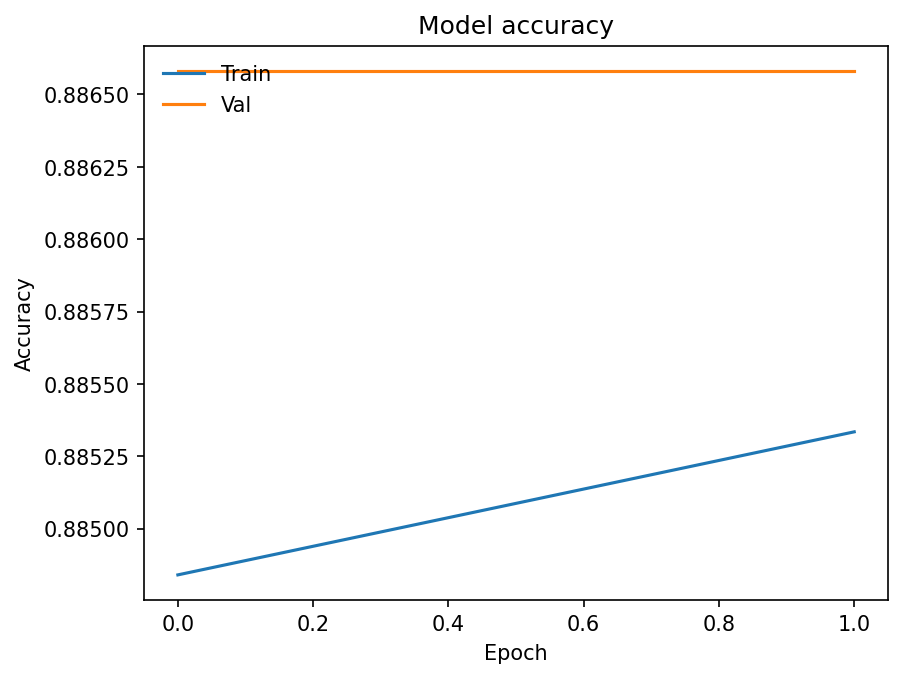

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

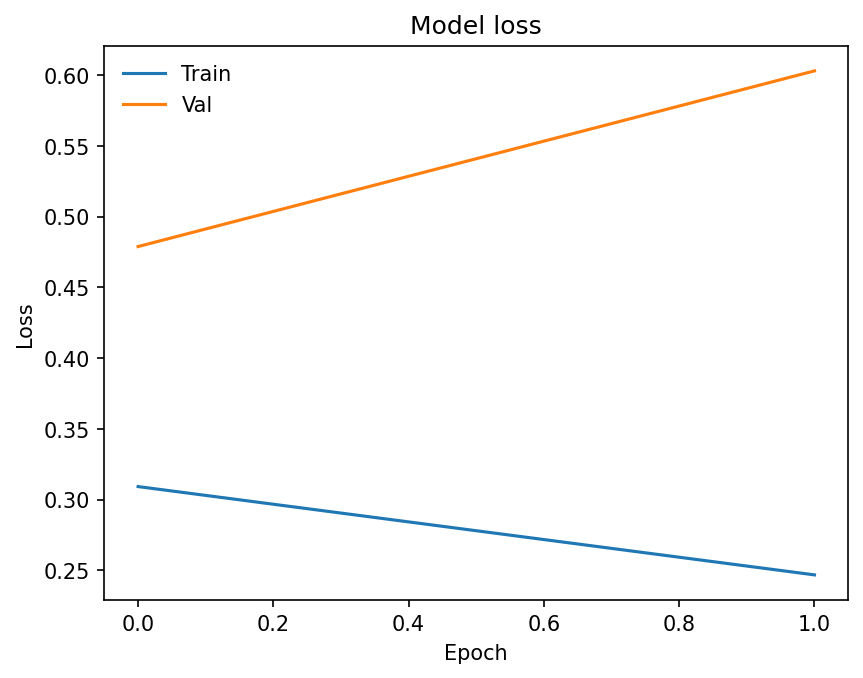

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

Confusion matrix

In [43]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred= model_aurisano.predict([testing[0],testing[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


In [44]:
#mat = confusion_matrix(label_testing,y_pred)
#plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names=class_names, show_normed=True)
#print(mat)

# $\nu_{\mu}$-classifier

In [45]:
def branch(input_img):
    x_view_1 = keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, padding='same')(input_img) # Added padding
    x_view_2 = keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3 = BatchNormalization()(x_view_2)
    x_view_4 = keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, padding='same')(x_view_3) # Added padding
    x_view_5 = keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_4)
    x_view_6 = BatchNormalization()(x_view_5)
    x_view_7 = keras.layers.Dropout(0.2)(x_view_6)
    x_view_8 = keras.layers.Flatten()(x_view_7)
    x_view_9 = keras.layers.Dense(32, activation='relu')(x_view_8)
    return keras.layers.Dense(16, activation='relu')(x_view_9)

In [46]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [47]:
combined = tf.keras.layers.Concatenate(axis=-1)([branch(input_img_1), branch(input_img_2)])
final_1 = Dense(32, activation='relu')(combined) # Adding an intermediate dense layer
flattened = Flatten()(final_1)
output = Dense(1, activation='sigmoid')(flattened) # Changed output layer

In [48]:
classifier = Model(inputs=[input_img_1, input_img_2], outputs=[output])
classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [49]:
classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 80,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 100, 80,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 50, 40,    │        272 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 50, 40,    │        272 │ input_layer_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 17, 14,    │          0 │ conv2d_96[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 17, 14,    │          0 │ conv2d_98[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 14,    │         64 │ max_pooling2d_28… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 14,    │         64 │ max_pooling2d_30… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 9, 7, 16)  │      4,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 9, 7, 16)  │      4,112 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 3, 3, 16)  │          0 │ conv2d_97[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 3, 3, 16)  │          0 │ conv2d_99[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 16)  │         64 │ max_pooling2d_29… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 16)  │         64 │ max_pooling2d_31… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3, 3, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 3, 3, 16)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 144)       │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 144)       │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      4,640 │ flatten_2[0][0] 

 Total params: 20,449 (79.88 KB)

 Trainable params: 20,321 (79.38 KB)

 Non-trainable params: 128 (512.00 B)

Order of magnitude reduction in number of parameters.

# Training

In [50]:
with tf.device("/cpu:0"):
    history_classifier = classifier.fit(
        [training[:, 0, :, :], training[:, 1, :, :]],
        label_training,
        batch_size=100,
        epochs=2,
        validation_data=(
            [validation[:, 0, :, :], validation[:, 1, :, :]],
            label_validation
        )
    )

2025-04-03 02:00:58.136528: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 712192000 exceeds 10% of free system memory.


Epoch 1/2
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.8397 - loss: 0.3914 - val_accuracy: 0.8866 - val_loss: 0.4365
Epoch 2/2
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.8815 - loss: 0.2841 - val_accuracy: 0.8866 - val_loss: 0.3355


In [51]:
with tf.device("/cpu:0"):
    history_classifier_smaller_batch = classifier.fit(
        [training[:, 0, :, :], training[:, 1, :, :]],
        label_training,
        batch_size=25,
        epochs=8,
        validation_data=(
            [validation[:, 0, :, :], validation[:, 1, :, :]],
            label_validation
        )
    )

Epoch 1/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8861 - loss: 0.2769 - val_accuracy: 0.8866 - val_loss: 0.3117
Epoch 2/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8831 - loss: 0.2592 - val_accuracy: 0.8850 - val_loss: 0.3103
Epoch 3/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8840 - loss: 0.2513 - val_accuracy: 0.8854 - val_loss: 0.3668
Epoch 4/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.8869 - loss: 0.2426 - val_accuracy: 0.8786 - val_loss: 0.3176
Epoch 5/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8848 - loss: 0.2381 - val_accuracy: 0.8403 - val_loss: 0.4383
Epoch 6/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.8870 - loss: 0.2280 - val_accuracy: 0.8866 - val_loss: 0.3336
Epoch 7/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8946 - loss: 0.2149 - val_accuracy: 0.8858 - val_loss: 0.6225
Epoch 8/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8950 - loss: 0.2123 - val_accu

In [52]:
with tf.device("/cpu:0"):
    history_classifier_smaller_batch_bal = classifier.fit(
        [training[:, 0, :, :], training[:, 1, :, :]],
        label_training,
        batch_size=25,
        epochs=8,
        validation_data=(
            [validation[:, 0, :, :], validation[:, 1, :, :]],
            label_validation
        )
    )

Epoch 1/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.8909 - loss: 0.2183 - val_accuracy: 0.8866 - val_loss: 1.1263
Epoch 2/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8947 - loss: 0.2074 - val_accuracy: 0.8690 - val_loss: 0.3421
Epoch 3/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8996 - loss: 0.2053 - val_accuracy: 0.8690 - val_loss: 0.3667
Epoch 4/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9009 - loss: 0.2019 - val_accuracy: 0.8830 - val_loss: 0.8558
Epoch 5/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9042 - loss: 0.1938 - val_accuracy: 0.4026 - val_loss: 1.0840
Epoch 6/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.9016 - loss: 0.1957 - val_accuracy: 0.4345 - val_loss: 0.8575
Epoch 7/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9069 - loss: 0.1876 - val_accuracy: 0.2177 - val_loss: 1.8567
Epoch 8/8
891/891 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9140 - loss: 0.1762 - val_accu

In [53]:
with tf.device("/cpu:0"):
    test_loss_classifier, test_acc_classifier = classifier.evaluate(
        [testing[:, 0, :, :], testing[:, 1, :, :]],
        label_testing,
        verbose=2
    )

96/96 - 1s - 14ms/step - accuracy: 0.8056 - loss: 0.4186


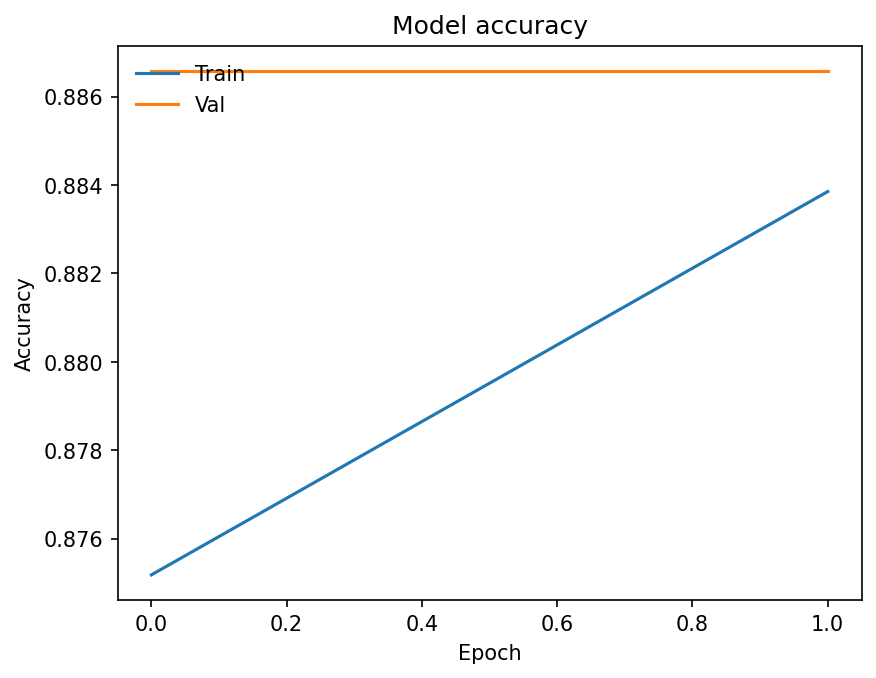

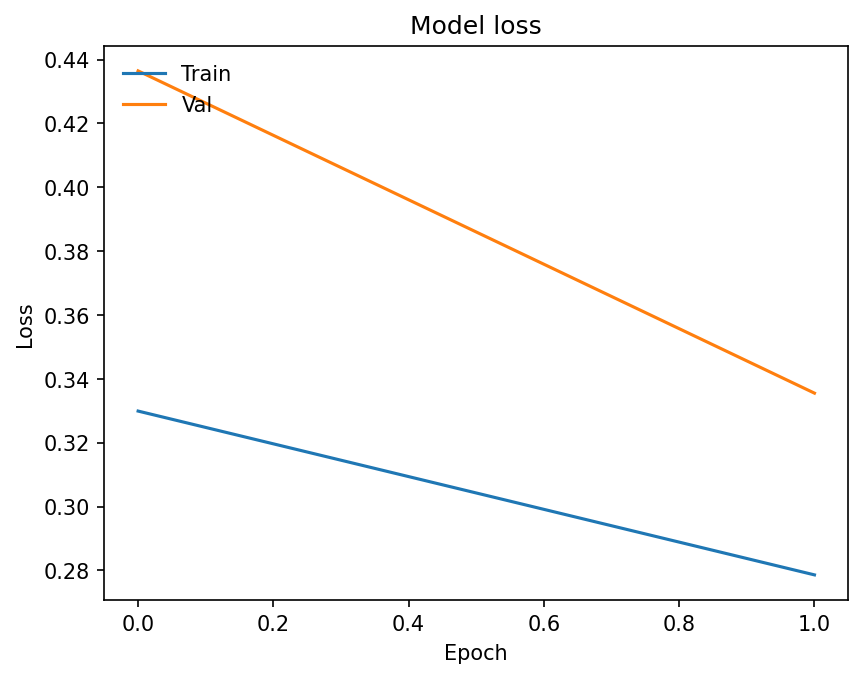

In [54]:
plt.plot(history_classifier.history['accuracy'])
plt.plot(history_classifier.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier.history['loss'])
plt.plot(history_classifier.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

# TESTING

In [55]:
events = {}

for i in range(1, 403):
    # Print the keys in the neutrino meta data
    #print(neutrino_files[f"df{i}"].keys())
    #print(neutrino_files[f"df{i}"]["neutrino"].keys())

    # Get a numpy array containing the event image, and reshape it from flat to 2x100x80
    #print(np.shape(neutrino_files[f"df{i}"]["cvnmap"]))
    #print(neutrino_files[f"df{i}"]["neutrino"]["evt"])
    events[f"event{i}"]=np.array(neutrino_files[f"df{i}"]["cvnmap"][3]).reshape((2,100,80))

NameError: name 'neutrino_files' is not defined

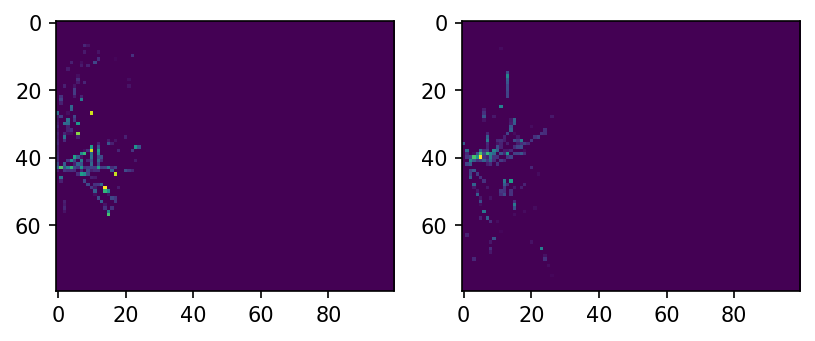

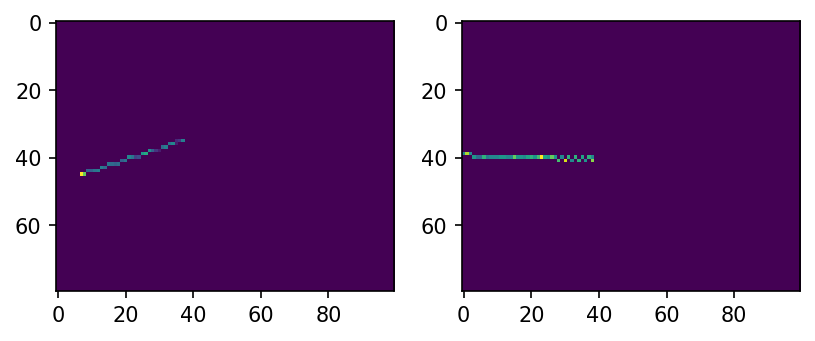

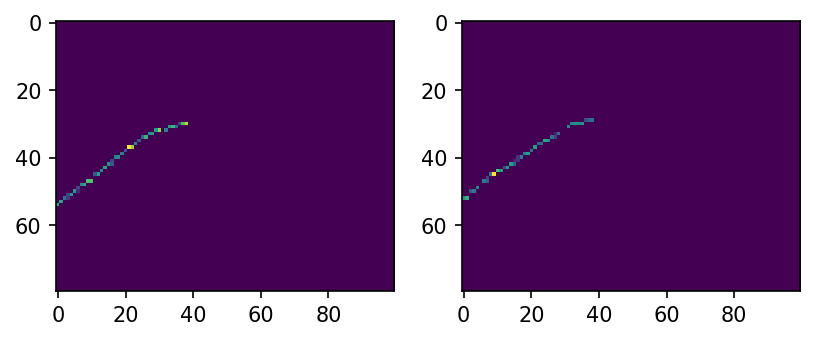

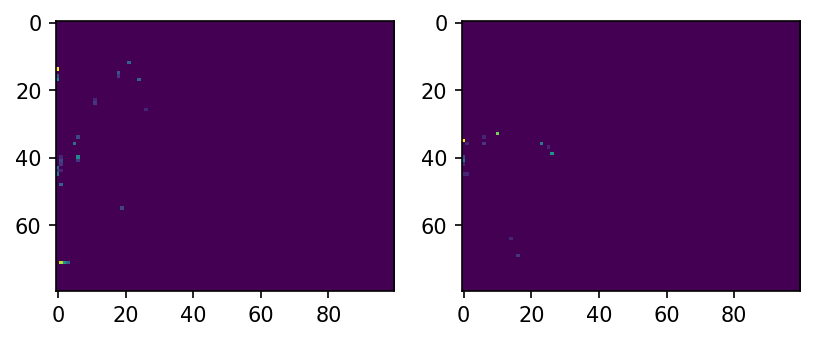

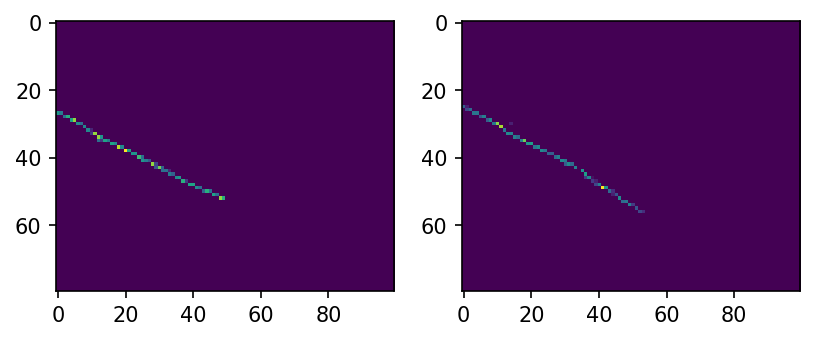

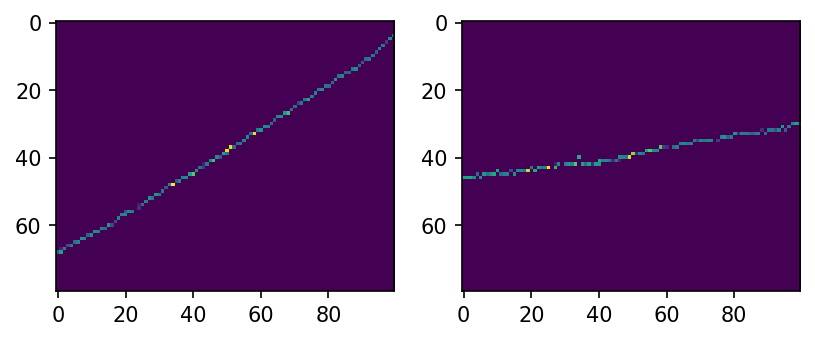

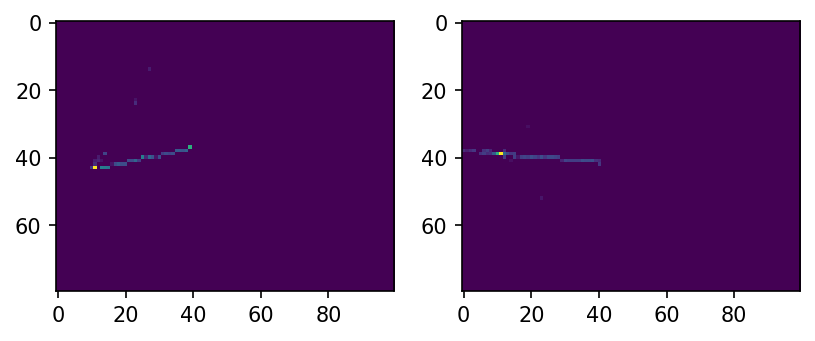

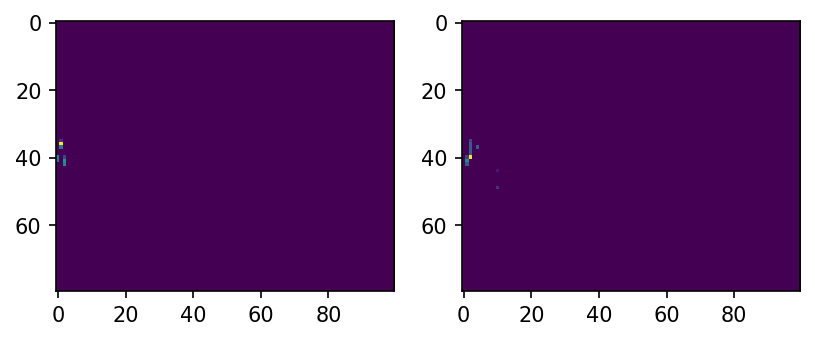

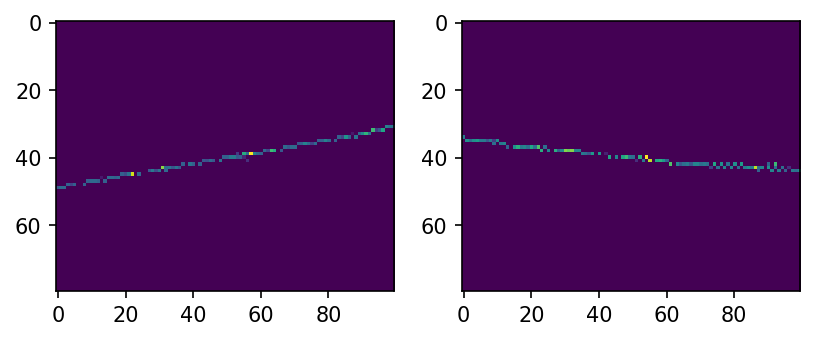

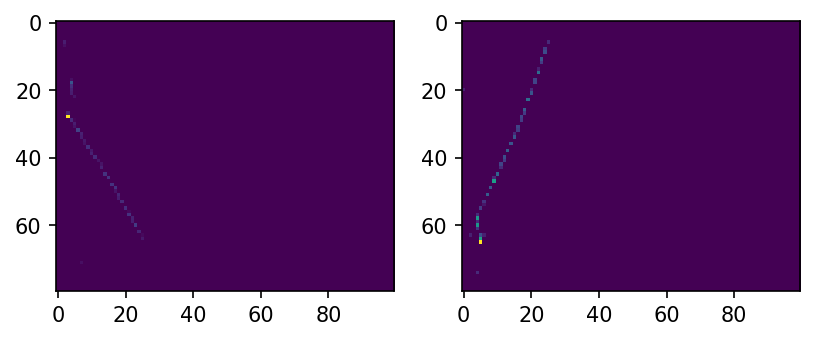

In [ ]:
"""
for i in range(1, 403):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(events[f"event{i}"][1].T)
    ax[1].imshow(events[f"event{i}"][0].T)
    
    filename = f"tracks/track{i}.png"
    # Save the figure
    plt.savefig(filename)
    plt.close(fig)
    print(f"Saved {filename}")
"""
for i in range(1, 11):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(events[f"event{i}"][1].T)
    ax[1].imshow(events[f"event{i}"][0].T)

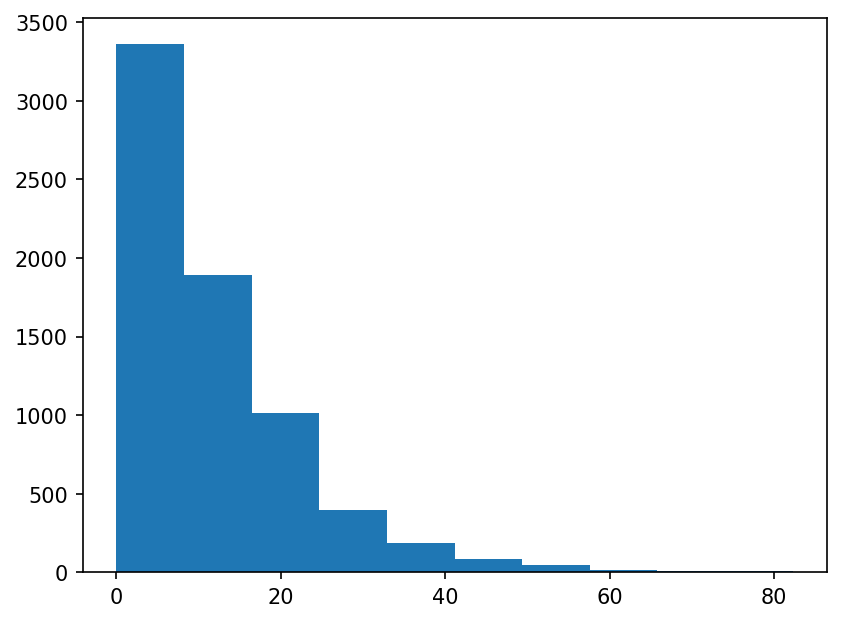

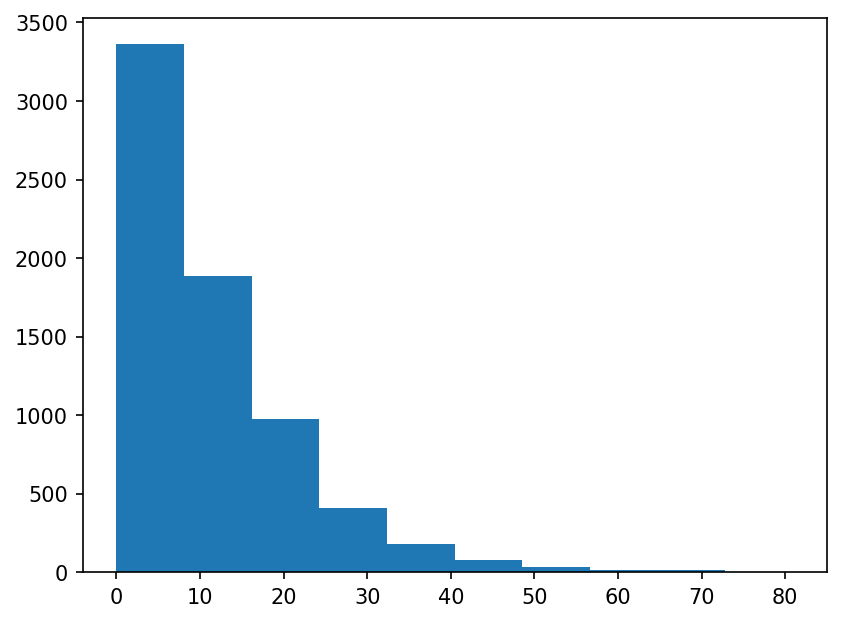

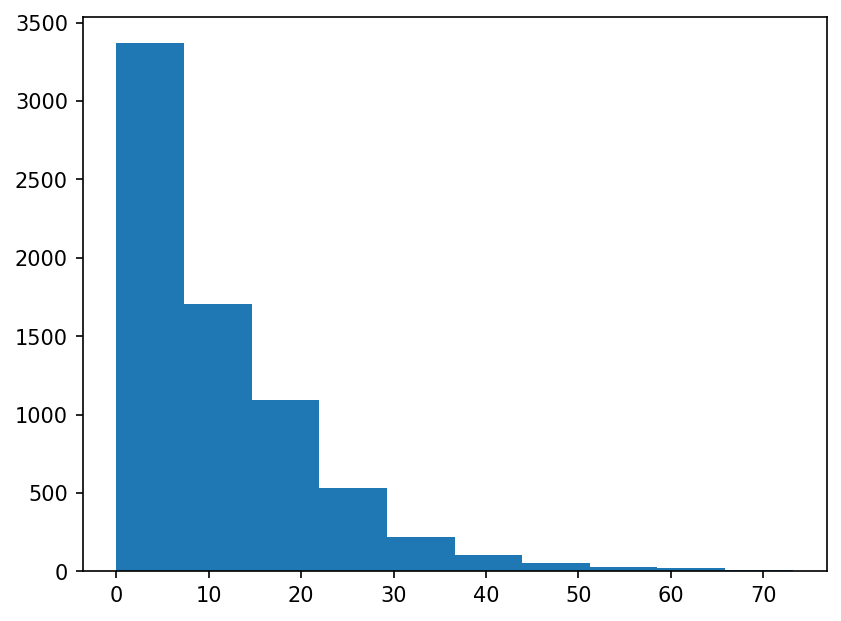

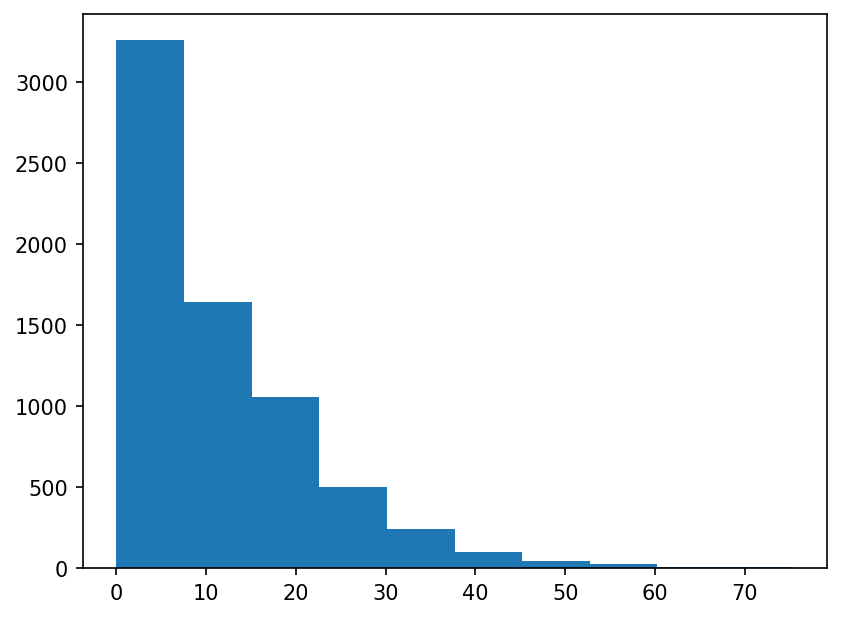

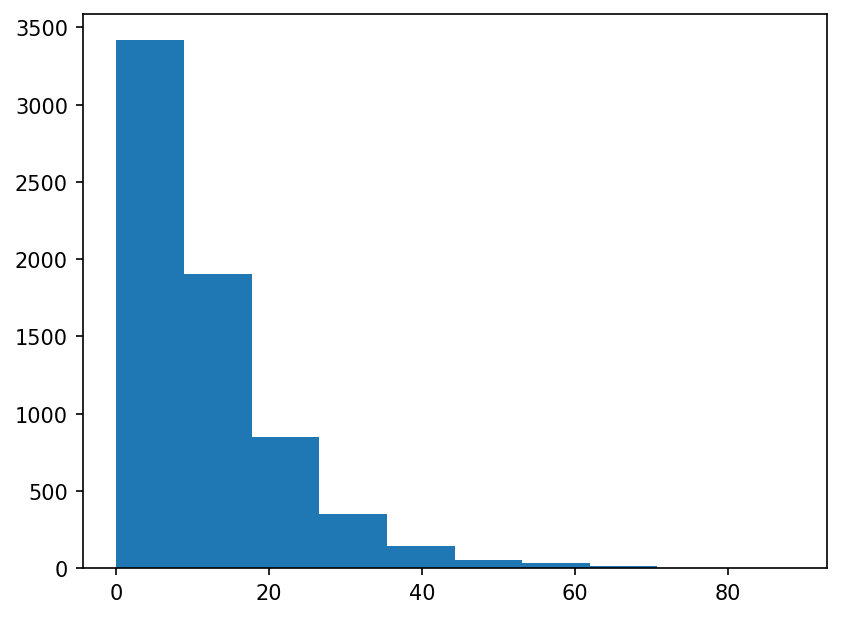

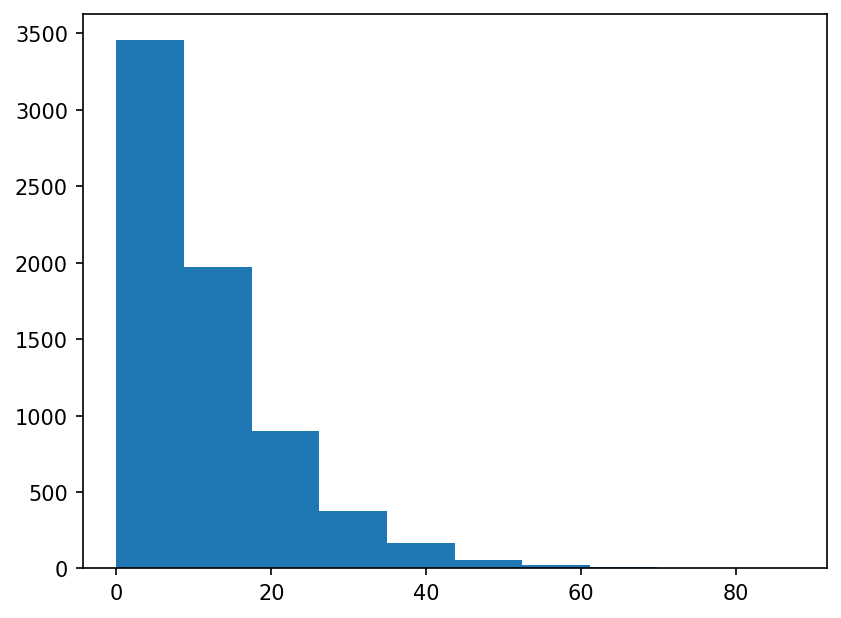

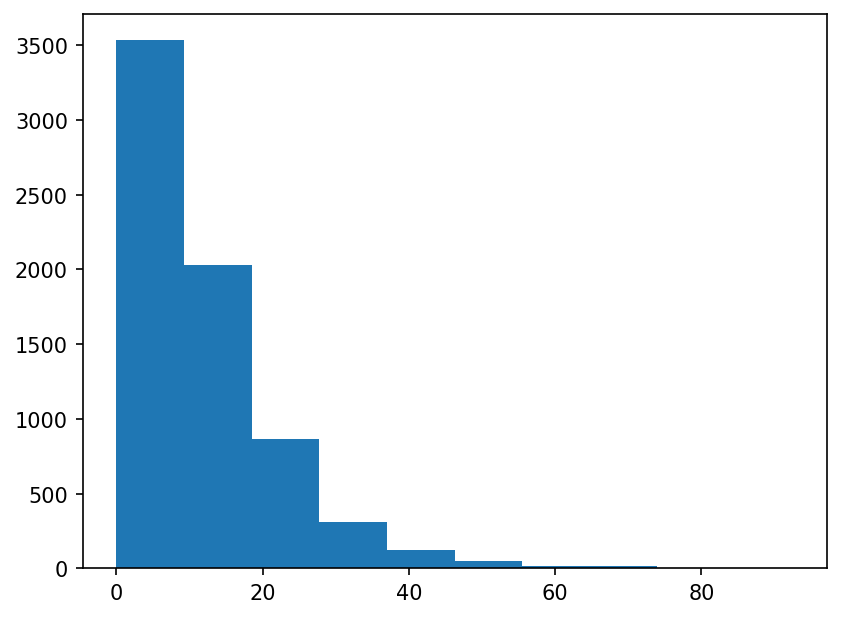

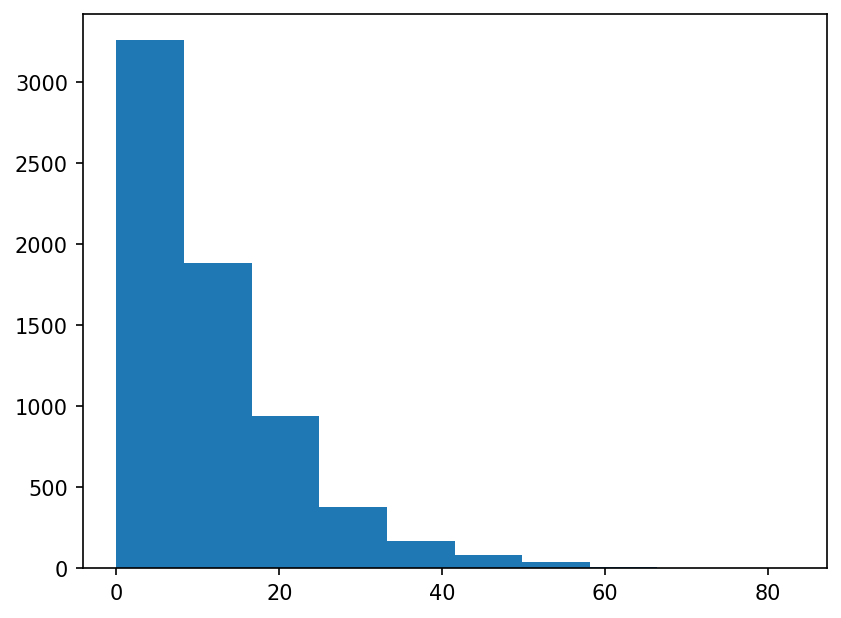

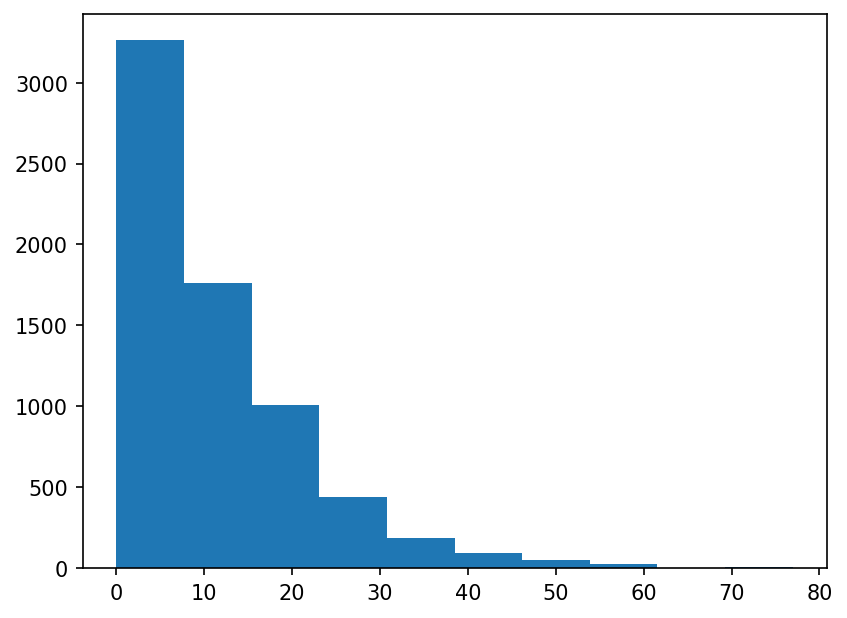

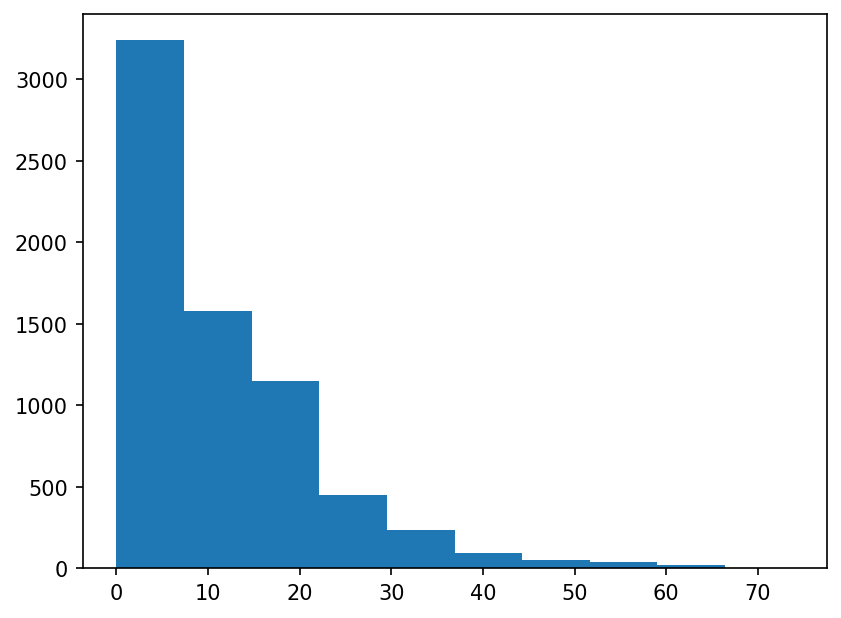

In [ ]:
for i in range(1, 11):
    fs=np.array(neutrino_files[f"df{i}"]["neutrino"]["finalstate"])
    nuenergy=np.array(neutrino_files[f"df{i}"]["neutrino"]["nuenergy"])
    fig, ax = plt.subplots()
    ax.hist(nuenergy)